In [1]:
# Imports cell
import pydicom
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])

In [5]:
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [6]:
# Functions used throughout project
def get_label_dict(filename):
     df = pd.read_csv(filename,index_col='SOPInstanceUID')
     df = df['Target'].str.split().apply(lambda x: [int(i) for i in x])
     # print(label_list)
     return df.to_dict()
     
def get_files():
     return glob('train/train/train/*/*/*/*'), glob('test/test/test/*/*/*/*') 

classes_to_body_parts = {
    0: 'Abdomen',
    1:'Ankle',
    2: 'Cervical Spine',
    3: 'Chest',
    4: 'Clavicles',
    5: 'Elbow',
    6: 'Feet',
    7: 'Finger',
    8: 'Forearm',
    9: 'Hand',
    10: 'Hip',
    11: 'Knee',
    12: 'Lower Leg',
    13: 'Lumbar Spine',
    14: 'Others',
    15: 'Pelvis',
    16: 'Shoulder',
    17: 'Sinus',
    18: 'Skull',
    19: 'Thigh',
    20: 'Thoracic Spine',
    21: 'Wrist'
}

def get_label_from_SOPID(index):
    return train_label_dict[index]

def load_train_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])

     
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     data['Label'] = data['index'].apply(get_label_from_SOPID)
     return data


def load_test_data(files):
     lst = [pydicom.dcmread(file).SOPInstanceUID for file in files]
     img_pixels = np.array([pydicom.dcmread(file).pixel_array.flatten() for file in files])
     data = pd.DataFrame(index=lst, data=img_pixels)
     data.reset_index(inplace=True)
     return data

def show_images(image_files, num_images = 20, class_names = None, exp_equal = False, others = False):
     body_labels = [classes_to_body_parts[_class[0]] for _class in class_names[:num_images]]
     for i, (im,lbl) in enumerate(zip(image_files[:num_images], body_labels)):
        plt.subplot(7, 10, i+1)
        if lbl is not None:
                plt.title(lbl if class_names is None else lbl)
        if (exp_equal):  
          plt.imshow(exp.equalize_hist(pydicom.dcmread(im).pixel_array), cmap='binary', interpolation='bilinear')
        else: 
          plt.imshow(pydicom.dcmread(im).pixel_array, cmap='binary', interpolation='bilinear')

        plt.axis('off')
        if others is True:
             plt.title("Others")
     plt.tight_layout()

train_label_dict = get_label_dict('train.csv')


In [8]:
train_files, test_files = get_files()

In [9]:
# loading train and test data
train_data = load_train_data(train_files)
test_data = load_test_data(test_files)

X_train = train_data.drop(columns=['index', 'Label'])
y_train = train_data['Label']


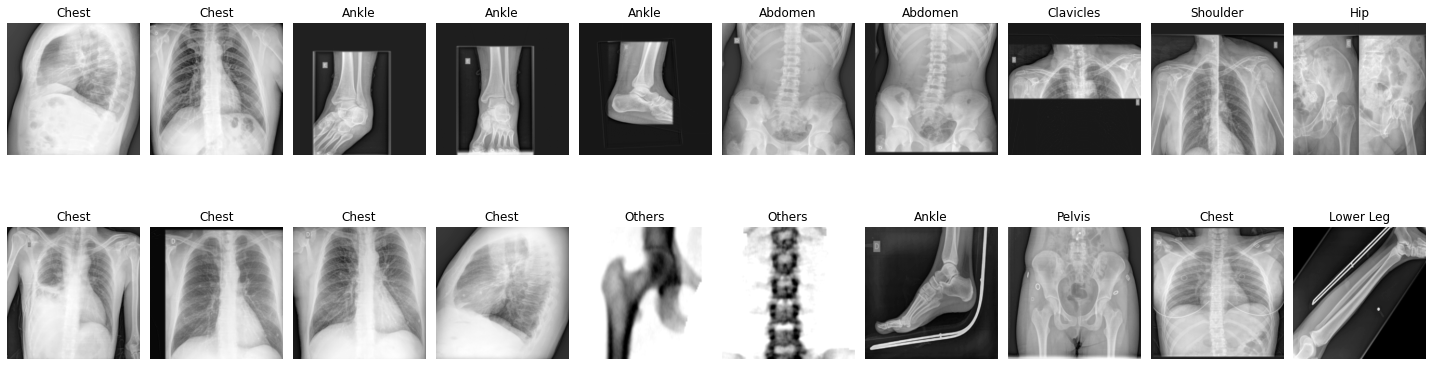

In [10]:
plt.figure(figsize=(20,20))
show_images(train_files, 20, class_names = train_data['Label'])

In [11]:
image_count = len(list(train_files))
print(image_count)
dataset_size = image_count


1738


In [12]:
import pathlib
train_dir = pathlib.Path('train/train/train')

In [13]:
image_count = len(list(train_dir.glob('*/*/*/*')))
print(image_count)

1738


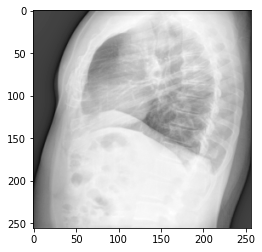

In [14]:
temp = list(train_dir.glob('*/*/*/*'))
plt.imshow(pydicom.dcmread(str(temp[0])).pixel_array, cmap='binary', interpolation='bilinear')


In [15]:
y_train = MultiLabelBinarizer().fit_transform(y_train)

In [16]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset

2022-05-03 12:08:45.956779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10538 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:af:00.0, compute capability: 7.0


<TensorSliceDataset element_spec=(TensorSpec(shape=(65536,), dtype=tf.uint16, name=None), TensorSpec(shape=(22,), dtype=tf.int64, name=None))>

In [21]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

In [22]:
duplicates = 4
train_size = int(0.7 * 1738*duplicates)
val_size = int(0.15 * 1738*duplicates)
test_size = int(0.15 * 1738*duplicates)

full_dataset = train_dataset.repeat(duplicates).shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

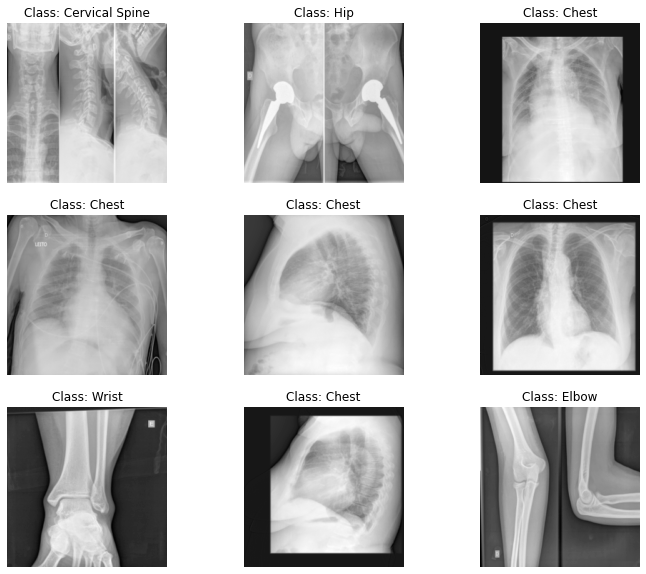

In [23]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_dataset.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(np.array(image).reshape(256, 256), cmap='binary', interpolation='bilinear')
    plt.title("Class: {}".format(classes_to_body_parts[np.argmax(label)]))
    plt.axis("off")

plt.show()

In [24]:
def preprocess(image, label):
    image = image.reshape(256, 256, 1)
    print("reshape")
    print(image.shape)
    print(image.dtype)
    # image = tf.cast()
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # rgb_image = cv2.convertScaleAbs(image)
    normalized_image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    print("normalized")
    print(normalized_image.shape)
    print(normalized_image.dtype)
    rgb_image = tf.image.grayscale_to_rgb(normalized_image)
    print("to rgb")
    print(rgb_image.shape)
    print(rgb_image.dtype)
    resized_image = tf.image.resize(rgb_image, [224, 224])
    print("resized")
    print(resized_image.shape)
    print(resized_image.dtype)
    # normalized_image = tf.cast(resized_image, tf.uint8) / 255.0
    final_image = keras.applications.xception.preprocess_input(resized_image)
    print("final")
    print(final_image.shape)
    print(final_image.dtype)
    return final_image, label

In [25]:
train_set = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(1)
valid_set = val_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(1)
test_set = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(1)

reshape
(256, 256, 1)
<dtype: 'uint16'>
normalized
(256, 256, 1)
<dtype: 'uint8'>
to rgb
(256, 256, 3)
<dtype: 'uint8'>
resized
(224, 224, 3)
<dtype: 'float32'>
final
(224, 224, 3)
<dtype: 'float32'>
reshape
(256, 256, 1)
<dtype: 'uint16'>
normalized
(256, 256, 1)
<dtype: 'uint8'>
to rgb
(256, 256, 3)
<dtype: 'uint8'>
resized
(224, 224, 3)
<dtype: 'float32'>
final
(224, 224, 3)
<dtype: 'float32'>
reshape
(256, 256, 1)
<dtype: 'uint16'>
normalized
(256, 256, 1)
<dtype: 'uint8'>
to rgb
(256, 256, 3)
<dtype: 'uint8'>
resized
(224, 224, 3)
<dtype: 'float32'>
final
(224, 224, 3)
<dtype: 'float32'>


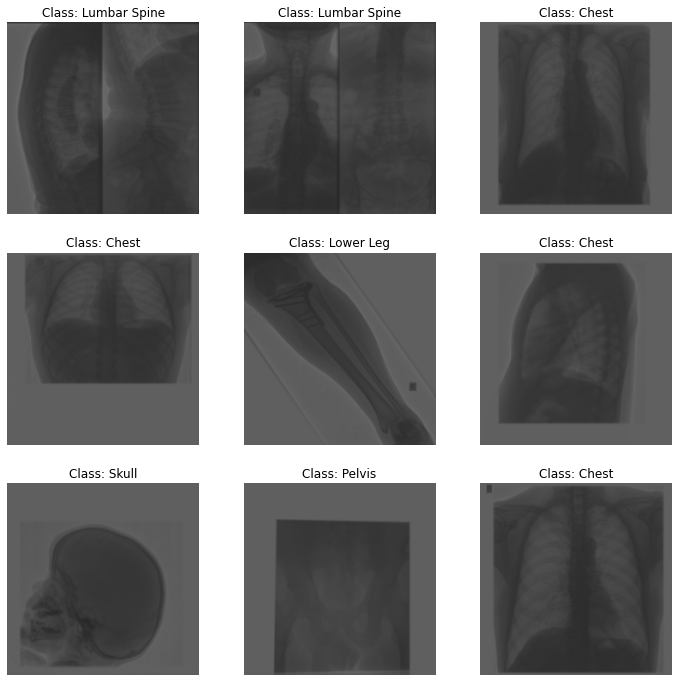

In [26]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5, cmap='binary', interpolation='bilinear')
        plt.title("Class: {}".format(classes_to_body_parts[np.argmax(y_batch[index])]))
        plt.axis("off")

plt.show()

In [28]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False, input_shape=(224,224,3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(22, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [29]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [30]:
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

In [31]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [32]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [33]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [34]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=macro_soft_f1, optimizer=optimizer,
              metrics=[macro_f1])
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=20)

Epoch 1/20


2022-05-03 12:08:55.710366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-05-03 12:08:56.554510: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-03 12:08:58.266219: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


20/20 [==============================] - 21s 510ms/step - loss: 0.8795 - macro_f1: 0.2901 - val_loss: 0.8149 - val_macro_f1: 0.4905
Epoch 2/20
20/20 [==============================] - 8s 401ms/step - loss: 0.7512 - macro_f1: 0.5632 - val_loss: 0.6915 - val_macro_f1: 0.6213
Epoch 3/20
20/20 [==============================] - 8s 390ms/step - loss: 0.6213 - macro_f1: 0.6529 - val_loss: 0.5840 - val_macro_f1: 0.6008
Epoch 4/20
20/20 [==============================] - 8s 387ms/step - loss: 0.5179 - macro_f1: 0.7049 - val_loss: 0.5098 - val_macro_f1: 0.6422
Epoch 5/20
20/20 [==============================] - 8s 405ms/step - loss: 0.4375 - macro_f1: 0.7356 - val_loss: 0.4338 - val_macro_f1: 0.6739
Epoch 6/20
20/20 [==============================] - 8s 396ms/step - loss: 0.3794 - macro_f1: 0.7645 - val_loss: 0.3778 - val_macro_f1: 0.7308
Epoch 7/20
20/20 [==============================] - 8s 416ms/step - loss: 0.3368 - macro_f1: 0.7683 - val_loss: 0.3522 - val_macro_f1: 0.7047
Epoch 8/20
20/20

In [35]:
# for layer in base_model.layers:
#     layer.trainable = False

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit(train_set,
#                     validation_data=valid_set,
#                     epochs=20)

In [36]:
history.history

{'loss': [0.8795478343963623,
  0.7511730194091797,
  0.6213342547416687,
  0.5178937911987305,
  0.43747857213020325,
  0.37943732738494873,
  0.33675137162208557,
  0.2985563278198242,
  0.27330052852630615,
  0.26208171248435974,
  0.25627657771110535,
  0.2325875163078308,
  0.22205965220928192,
  0.21929387748241425,
  0.19562844932079315,
  0.19503366947174072,
  0.18559633195400238,
  0.18538905680179596,
  0.18482445180416107,
  0.17350983619689941],
 'macro_f1': [0.2900790572166443,
  0.5632344484329224,
  0.6528720259666443,
  0.7048652172088623,
  0.7355509400367737,
  0.7644938230514526,
  0.7682710886001587,
  0.7965658903121948,
  0.8000256419181824,
  0.8017727732658386,
  0.7898578643798828,
  0.8109400868415833,
  0.8130134344100952,
  0.8133400678634644,
  0.8290182948112488,
  0.8295770883560181,
  0.8300762176513672,
  0.8278961181640625,
  0.823165237903595,
  0.8326543569564819],
 'val_loss': [0.8149208426475525,
  0.6915416717529297,
  0.5839967727661133,
  0.509

In [37]:
print("Evaluate model on test data")
results = model.evaluate(test_set, batch_size=BATCH_SIZE)
print("test loss, test macro_f1:", results)

Evaluate model on test data
5/5 [==============================] - 3s 518ms/step - loss: 0.1891 - macro_f1: 0.7627
test loss, test acc: [0.1890973448753357, 0.7626631855964661]


In [38]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_set.take(1))
print("prediction shape:", prediction.shape)
prediction

Generate a prediction
prediction shape: (256, 22)


array([[5.0388236e-04, 1.3056141e-03, 1.6449472e-02, ..., 1.0909562e-03,
        3.1324118e-05, 4.7196710e-04],
       [4.9355622e-06, 4.8144930e-03, 8.0433718e-05, ..., 3.5806936e-06,
        1.2136771e-04, 9.9762964e-01],
       [9.9960679e-01, 2.4917351e-06, 5.5548382e-05, ..., 4.3651522e-09,
        6.3473311e-07, 4.6593791e-06],
       ...,
       [1.3321232e-05, 1.6635588e-04, 4.0406385e-03, ..., 1.7852140e-06,
        1.4529036e-02, 1.4880954e-03],
       [8.7017911e-03, 1.8946021e-03, 4.6631569e-04, ..., 2.4320829e-05,
        5.5292720e-04, 6.8322103e-04],
       [6.6942977e-07, 4.0384224e-03, 9.5879159e-06, ..., 7.4987843e-06,
        9.3591261e-06, 9.8199511e-01]], dtype=float32)

In [45]:
prediction[0]

array([5.0388236e-04, 1.3056141e-03, 1.6449472e-02, 5.2470218e-02,
       4.1618555e-06, 2.5172430e-04, 1.1605202e-02, 7.8952475e-08,
       3.2360395e-04, 3.3644389e-04, 9.7036934e-01, 1.6560491e-04,
       1.4326553e-03, 8.7930173e-05, 6.2035826e-05, 1.1957877e-05,
       5.8010191e-04, 6.4158435e-06, 2.3450710e-05, 1.0909562e-03,
       3.1324118e-05, 4.7196710e-04], dtype=float32)

In [47]:
np.argmax(prediction[0])

10

In [56]:
ds=test_set
predictions= model.predict(ds.take(10))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred)

A sample output from the last layer (model)  [6.83376447e-06 1.93631087e-04 1.03232360e-05 9.99321103e-01
 8.81768244e-07 1.20260992e-07 2.61066249e-03 5.40020721e-08
 1.61054118e-07 5.75135391e-06 1.38354315e-08 1.54592926e-05
 6.50116681e-06 1.93500418e-05 8.10714755e-06 7.63833759e-06
 1.59769297e-05 1.20091144e-07 6.80570054e-08 8.08806035e-08
 2.24190117e-05 3.56080345e-05]
10 Sample predictions:
predicted:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [39]:
# for layer in base_model.layers:
#     layer.trainable = True

# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
#                                  nesterov=True, decay=0.001)
# model.compile(loss="categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# with tf.device("/device:CPU:0"):
#     history = model.fit(train_set,
#                     validation_data=valid_set,
#                     epochs=40)

In [59]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

2022-05-03 12:32:08.066063: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/soft-f1_20220503_123202/assets
Model with macro soft-f1 was exported in this path: './models/soft-f1_20220503_123202'
